# Ensemble Learning on House Prices - Blending • Bagging • Stacking


## 1. Ensemble Learning

### Objectives
- Grasp essential ensemble concepts and when to use them.
- Implement **Blending**, **Bagging**, and **Stacking** on a small, realistic dataset.

In [1]:
# Imports & setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple, Callable

# scikit-learn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

np.random.seed(42)

# Matplotlib preferences
plt.rcParams["figure.figsize"] = (7.5, 5.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

## Preparing Dataset


In [2]:
# Load the Kaggle House Prices training data
csv_path = "/content/train.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Couldn't find House Prices training data at {csv_path}")

df = pd.read_csv(csv_path)
needed_cols = ["SalePrice", "GrLivArea", "YearBuilt"]
missing = [c for c in needed_cols if c not in df.columns]
if missing:
    raise ValueError(f"Expected columns {needed_cols} not found: missing {missing}")

# Keep only the needed columns and drop rows with missing values
df_small = df[needed_cols].dropna().copy()

X = df_small[["GrLivArea", "YearBuilt"]].values.astype(float)
y = df_small["SalePrice"].values.astype(float)

# Train/validation split: 80/20
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "  Val shape:", X_val.shape)
print("Targets: min=", y.min(), " max=", y.max(), " median=", np.median(y))

Train shape: (1168, 2)   Val shape: (292, 2)
Targets: min= 34900.0  max= 755000.0  median= 163000.0


## Baseline Single Models (scikit-learn)


In [3]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# Pipelines / models
model_lr = LinearRegression()
model_svr = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=100.0, epsilon=0.1, gamma="scale"))
model_dt = DecisionTreeRegressor(max_depth=6, random_state=42)

models = {
    "LinearRegression": model_lr,
    "SVR(RBF)+Scaler": model_svr,
    "DecisionTree(max_depth=6)": model_dt,
}

single_results = {}
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    pred_val = mdl.predict(X_val)
    single_results[name] = {
        "MSE": mean_squared_error(y_val, pred_val),
        "RMSE": rmse(y_val, pred_val),
        "preds": pred_val,
        "model": mdl,
    }

# Show summary table
res_df = pd.DataFrame({k: {"MSE": v["MSE"], "RMSE": v["RMSE"]} for k,v in single_results.items()}).T
res_df = res_df.sort_values("RMSE")
res_df

,MSE,RMSE
DecisionTree(max_depth=6),1.500626e+09,38737.91959
LinearRegression,2.495555e+09,49955.52921
SVR(RBF)+Scaler,6.418571e+09,80115.98452


### Validation Performance (RMSE)


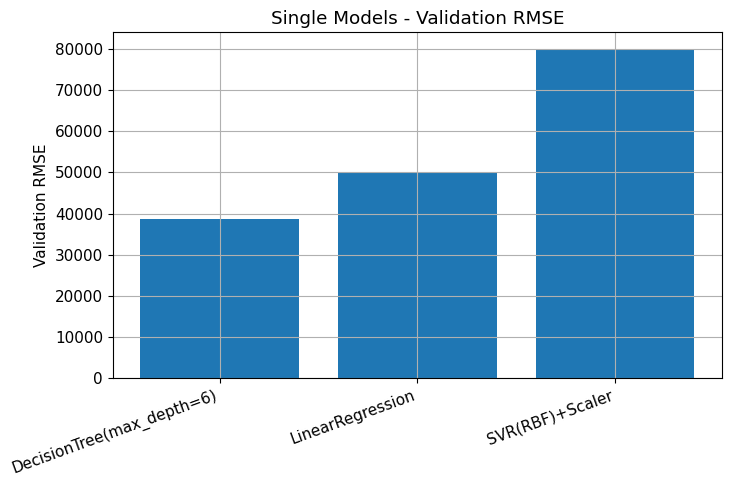

In [5]:
fig = plt.figure()
plt.bar(range(len(res_df)), res_df["RMSE"].values)
plt.xticks(range(len(res_df)), res_df.index, rotation=20, ha="right")
plt.ylabel("Validation RMSE")
plt.title("Single Models - Validation RMSE")
plt.tight_layout()
plt.show()


## 3. Blending (from scratch)

**Idea:** Train models independently; combine their predictions with **weights**.


In [6]:
base_pred_val = np.vstack([
    single_results["LinearRegression"]["preds"],
    single_results["SVR(RBF)+Scaler"]["preds"],
    single_results["DecisionTree(max_depth=6)"]["preds"],
]).T  # shape (N_val, 3)

def grid_search_blend_weights(y_true, pred_matrix, step=0.05):
    best = {"w": None, "MSE": np.inf, "RMSE": np.inf}
    ws = np.arange(0, 1+1e-9, step)
    for w1 in ws:
        for w2 in ws:
            w3 = 1.0 - w1 - w2
            if w3 < -1e-12:
                continue
            w = np.array([w1, w2, max(0.0, w3)])
            y_blend = pred_matrix @ w
            mse = mean_squared_error(y_true, y_blend)
            if mse < best["MSE"]:
                best["MSE"] = mse
                best["RMSE"] = float(np.sqrt(mse))
                best["w"] = w.copy()
    return best

blend_best = grid_search_blend_weights(y_val, base_pred_val, step=0.05)
blend_rmse = blend_best["RMSE"]
blend_mse = blend_best["MSE"]
blend_w = blend_best["w"]

print("Blending best weights [LR, SVR, DT]:", blend_w)
print("Blending MSE:", blend_mse, " RMSE:", blend_rmse)

Blending best weights [LR, SVR, DT]: [0.05 0.   0.95]
Blending MSE: 1495097327.5698042  RMSE: 38666.48843080794



## 4. Bagging


In [7]:
class ScratchBaggingRegressor:
    def __init__(self, base_estimator_factory: Callable[[], object], n_estimators=50, random_state=42):
        self.base_estimator_factory = base_estimator_factory
        self.n_estimators = int(n_estimators)
        self.random_state = int(random_state)
        self.models = []

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        N = X.shape[0]
        self.models = []
        for i in range(self.n_estimators):
            idx = rng.integers(0, N, size=N)  # bootstrap
            Xi, yi = X[idx], y[idx]
            m = self.base_estimator_factory()
            m.fit(Xi, yi)
            self.models.append(m)
        return self

    def predict(self, X):
        preds = np.column_stack([m.predict(X) for m in self.models])
        return preds.mean(axis=1)

# Bag Decision Trees
bag = ScratchBaggingRegressor(base_estimator_factory=lambda: DecisionTreeRegressor(max_depth=6, random_state=np.random.randint(0, 10_000)),
                              n_estimators=80, random_state=42)
bag.fit(X_train, y_train)
pred_bag = bag.predict(X_val)
bag_mse = mean_squared_error(y_val, pred_bag)
bag_rmse = rmse(y_val, pred_bag)
print("Bagging - MSE:", bag_mse, " RMSE:", bag_rmse)

Bagging - MSE: 1527890778.059147  RMSE: 39088.24347625699


## 5. Stacking

**Idea:** Use **level-0** models to create new features via their predictions, then train a **meta-model** on those predictions.


In [8]:
class ScratchStackingRegressor:
    def __init__(self, base_models: List[object], meta_model=None, n_folds=5, random_state=42):
        self.base_models = base_models
        self.meta_model = RidgeCV(alphas=(0.1, 1.0, 10.0)) if meta_model is None else meta_model
        self.n_folds = int(n_folds)
        self.random_state = int(random_state)
        self.fitted_base_models_ = None
        self.fitted_meta_model_ = None

    def fit(self, X, y):
        X = np.asarray(X); y = np.asarray(y)
        N = X.shape[0]
        K = len(self.base_models)
        oof = np.zeros((N, K), dtype=float)

        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        for fold, (tr, va) in enumerate(kf.split(X)):
            Xtr, Xva = X[tr], X[va]
            ytr = y[tr]
            # Fit clones of base models
            for j, model in enumerate(self.base_models):
                # Recreate fresh model by copying parameters (simplest: use new instances)
                # For pipelines with no simple get_params, we reinstantiate explicitly:
                if isinstance(model, LinearRegression):
                    m = LinearRegression()
                elif isinstance(model, DecisionTreeRegressor):
                    # Use same depth for consistency
                    m = DecisionTreeRegressor(max_depth=model.max_depth, random_state=42+fold+j)
                elif isinstance(model, tuple) and model[0] == "SVR_RBF":
                    # stored as ("SVR_RBF",) marker -> rebuild pipeline
                    m = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=100.0, epsilon=0.1, gamma="scale"))
                else:
                    # default: try to clone via parameters
                    m = type(model)(**getattr(model, "get_params", lambda: {})())
                m.fit(Xtr, ytr)
                oof[va, j] = m.predict(Xva)

        # Fit meta-model on OOF preds
        self.fitted_meta_model_ = self.meta_model.fit(oof, y)
        # Fit base models on full data to use later in predict
        self.fitted_base_models_ = []
        for model in self.base_models:
            if isinstance(model, LinearRegression):
                m = LinearRegression()
            elif isinstance(model, DecisionTreeRegressor):
                m = DecisionTreeRegressor(max_depth=model.max_depth, random_state=42)
            elif isinstance(model, tuple) and model[0] == "SVR_RBF":
                m = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=100.0, epsilon=0.1, gamma="scale"))
            else:
                m = type(model)(**getattr(model, "get_params", lambda: {})())
            m.fit(X, y)
            self.fitted_base_models_.append(m)
        return self

    def predict(self, X):
        # Get level-0 predictions as features
        Z = np.column_stack([m.predict(X) for m in self.fitted_base_models_])
        return self.fitted_meta_model_.predict(Z)

# Prepare base models for stacking (SVR is a marker tuple to rebuild easily)
stack_base = [
    LinearRegression(),
    ("SVR_RBF",),
    DecisionTreeRegressor(max_depth=6, random_state=42),
]
stack_meta = RidgeCV(alphas=(0.1, 1.0, 10.0))

stack = ScratchStackingRegressor(base_models=stack_base, meta_model=stack_meta, n_folds=5, random_state=42)
stack.fit(X_train, y_train)
pred_stack = stack.predict(X_val)
stack_mse = mean_squared_error(y_val, pred_stack)
stack_rmse = rmse(y_val, pred_stack)
print("Stacking - MSE:", stack_mse, " RMSE:", stack_rmse)

Stacking - MSE: 2056836765.528773  RMSE: 45352.36229270503



## 6. Results Summary
We compare single models and the three ensemble methods on the same validation split.


In [9]:
summary = {
    "LinearRegression": single_results["LinearRegression"]["RMSE"],
    "SVR(RBF)+Scaler": single_results["SVR(RBF)+Scaler"]["RMSE"],
    "DecisionTree(max_depth=6)": single_results["DecisionTree(max_depth=6)"]["RMSE"],
    "Blending (grid weights)": blend_rmse,
    "Bagging (DT x80)": bag_rmse,
    "Stacking (LR+SVR+DT -> RidgeCV)": stack_rmse,
}
summary_df = pd.DataFrame.from_dict(summary, orient="index", columns=["RMSE"]).sort_values("RMSE")
summary_df

,RMSE
Blending (grid weights),38666.488431
DecisionTree(max_depth=6),38737.919590
Bagging (DT x80),39088.243476
Stacking (LR+SVR+DT -> RidgeCV),45352.362293
LinearRegression,49955.529210
SVR(RBF)+Scaler,80115.984520


### RMSE Comparison

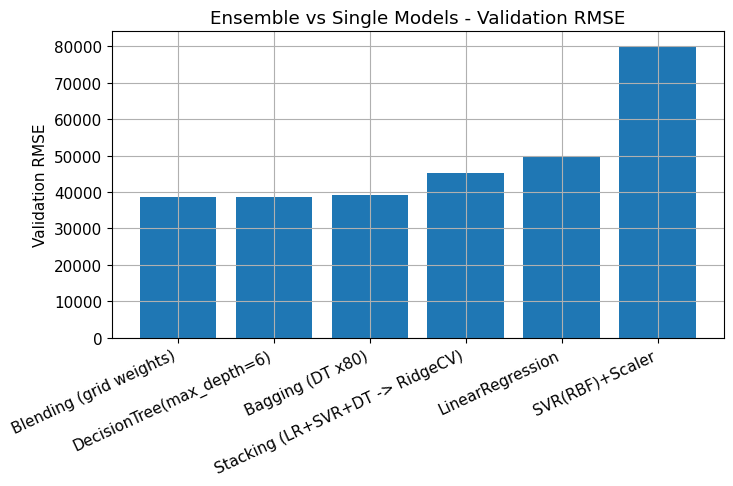

In [10]:
fig = plt.figure()
plt.bar(range(len(summary_df)), summary_df["RMSE"].values)
plt.xticks(range(len(summary_df)), summary_df.index, rotation=25, ha="right")
plt.ylabel("Validation RMSE")
plt.title("Ensemble vs Single Models - Validation RMSE")
plt.tight_layout()
plt.show()

### Diagnostic Plots


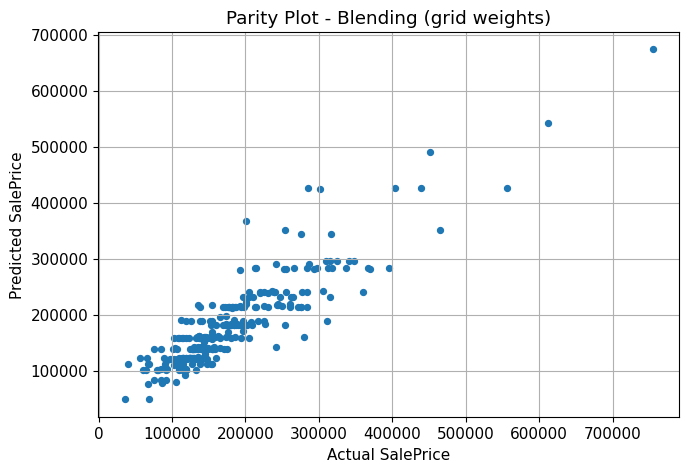

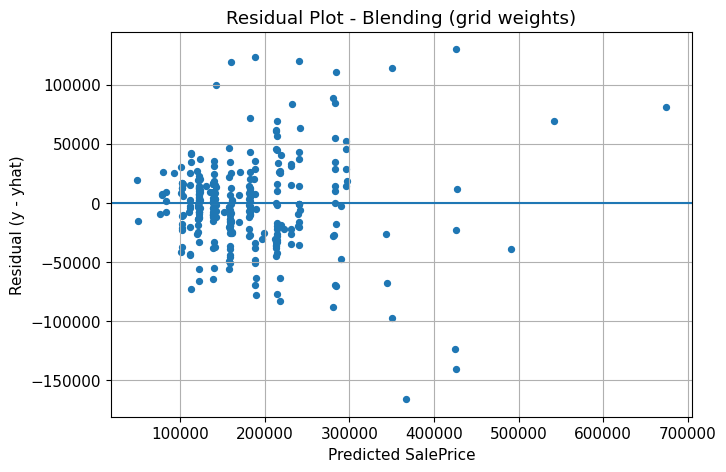

In [11]:
best_name = summary_df.index[0]
if best_name.startswith("Blending"):
    # Recompute blended preds
    y_best = base_pred_val @ blend_w
elif best_name.startswith("Bagging"):
    y_best = pred_bag
elif best_name.startswith("Stacking"):
    y_best = pred_stack
else:
    y_best = single_results[best_name]["preds"]

fig = plt.figure()
plt.scatter(y_val, y_best, s=18)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title(f"Parity Plot - {best_name}")
plt.show()

resid = y_val - y_best
fig = plt.figure()
plt.scatter(y_best, resid, s=18)
plt.axhline(0.0)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual (y - yhat)")
plt.title(f"Residual Plot - {best_name}")
plt.show()

As expected, blending reduced the overall MSE and consequently the RMSE